In [2]:
# Importation 
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import os
import openpyxl
from tsfresh import extract_features, select_features
directory = os.getcwd()

# Graphe d'évolution du NDVI

<AxesSubplot:title={'center':"Evolution du NDVI sur l'année"}, xlabel='date', ylabel='NDVI'>

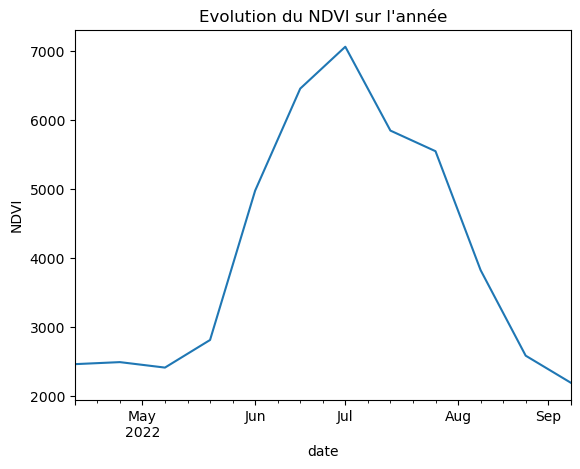

In [3]:
# Importation données NDVI
donnees = pd.read_csv(f"{directory}/donnees/resultats-2.csv", sep = ";", parse_dates = ["date"], dayfirst = True)

# Typage des colonnes
donnees['parcelle'] = donnees['parcelle'].astype('string')
donnees["parcelle"] = donnees["parcelle"].map(lambda x:x.replace('_','').lower())
donnees.columns = donnees.columns.str.replace('NDVI_moy', 'ndvi')
donnees = donnees.set_index('date', drop = False)

donnees["campagne"] = donnees["date"].dt.year # on utilise cette colonne campagne pour les jointures pr récup le peuplement et le précédent
donnees['campagne'] = donnees['campagne'].astype('string')

# Graphe évolution NDVI moyenné par mois
# sns.lineplot(x="date", y="ndvi", data=donnees, hue="parcelle", legend = False)
donnees["ndvi"].resample("2W").mean().plot(title = "Evolution du NDVI sur l'année", ylabel = "NDVI")

# Intégration du target (peuplement)

In [4]:
peuplement_1 = pd.read_excel(f"{directory}/donnees/peuplement/donnees2022_BA-2.xlsx", engine='openpyxl', parse_dates = ["date"])
peuplement_1 = peuplement_1.loc[:,["parcelle","date","peuplement"]]
#print(peuplement_1)

peuplement_2 = pd.read_excel(f"{directory}/donnees/peuplement/Placette_TRN22_beauce.xlsx", engine='openpyxl', parse_dates = ["date_obs"])
peuplement_2 = peuplement_2.loc[:,["numero_parcelle","date_obs","peuplement"]]
peuplement_2.columns = peuplement_2.columns.str.replace('numero_parcelle', 'parcelle')
peuplement_2.columns = peuplement_2.columns.str.replace('date_obs','date')
peuplement_2 = peuplement_2[peuplement_2["parcelle"] != "80_22"] # la dernière ligne a un NA dans col peuplement
#print(peuplement_2)

peuplement = peuplement_1.merge(peuplement_2)
peuplement = pd.concat([peuplement_1, peuplement_2], axis = 0, ignore_index = True) #on concatène les tables
peuplement["parcelle"] = peuplement["parcelle"].map(lambda x:x.replace('_','').lower())
peuplement['parcelle'] = peuplement['parcelle'].astype('string') #on reformate
peuplement = peuplement.groupby(["parcelle"]).agg({"date":["first"], "peuplement":["mean"]}) #on regroupe toutes les lignes par sa valeur unique de parcelle
peuplement.columns = peuplement.columns.droplevel()
peuplement.columns = ["date","peuplement"]
peuplement = peuplement.reset_index()

# Intégration aux données NDVI
peuplement["campagne"] = peuplement["date"].dt.year.map(lambda x:int(x))
peuplement['campagne'] = peuplement['campagne'].astype('string')
peuplement = peuplement.drop(["date"], axis = 1)

donnees = donnees.merge(peuplement,on=['campagne','parcelle'],how='left')

donnees['parcelle'] = donnees['parcelle'].astype('string')

'''Les donnees dans la table "donnees" sont au final classées comme dans la feuille "resultats_2" avec 650 lignes.
Chaque ligne indique donc une parcelle, une date, la campagne (année), le ndvi mesuré, et le peuplement ramené au 
peuplement moyen sur l'année pour chaque parcelle'''

       parcelle       date  ndvi campagne  peuplement
0           222 2022-05-10  3255     2022         NaN
1           222 2022-06-14  7444     2022         NaN
2           222 2022-06-19  6815     2022         NaN
3           222 2022-07-14  5632     2022         NaN
4           222 2022-07-24  4573     2022         NaN
..          ...        ...   ...      ...         ...
645  tivillers8 2022-08-17  2002     2022     82000.0
646  tivillers8 2022-08-20  2106     2022     82000.0
647  tivillers8 2022-08-22  1807     2022     82000.0
648  tivillers8 2022-08-25  1835     2022     82000.0
649  tivillers8 2022-08-30  2051     2022     82000.0

[650 rows x 5 columns]


'Les donnees dans la table "donnees" sont au final classées comme dans la feuille "resultats_2" avec 650 lignes.\nChaque ligne indique donc une parcelle, une date, la campagne (année), le ndvi mesuré, et le peuplement ramené au \npeuplement moyen sur l\'année pour chaque parcelle'

# Intégration des données cultures précédentes

In [5]:
# Fichiers avec données cultures précédentes
filenames = glob.glob(f"{directory}/donnees/precedents/*.csv")

# tableau où on agrège toutes les données cultures précédentes
donnees_precedent = pd.read_csv(filenames[0], sep = ";")

for file in filenames[1:]:
    donnees_precedent_tmp = pd.read_csv(file, sep = ";")
    donnees_precedent = pd.concat([donnees_precedent,donnees_precedent_tmp], axis = 0)

donnees_precedent = donnees_precedent.drop(["ID_PARCEL"], axis = 1)

# Typage des colonnes
donnees_precedent.columns = donnees_precedent.columns.str.replace('CODE_CULTU', 'precedent')
donnees_precedent['precedent'] = donnees_precedent['precedent'].astype('string')
donnees_precedent['campagne'] = donnees_precedent['campagne'].astype('string')
donnees_precedent["NomPar"] = donnees_precedent["NomPar"].map(lambda x:x.replace('_','').lower())
donnees_precedent.columns = donnees_precedent.columns.str.replace('NomPar', 'parcelle')
donnees_precedent['parcelle'] = donnees_precedent['parcelle'].astype('string')

# Jointure avec table de données NDVI
donnees = donnees.merge(donnees_precedent,on=['campagne','parcelle'],how='left')

print("nombre de couples parcelle-campagne : ", donnees.loc[:,["parcelle","campagne"]].drop_duplicates().shape[0])
print("nombre de couples parcelle-campagne pour lesquels on n'a pas le précédent : ", donnees.iloc[donnees.loc[:,["parcelle","campagne"]].drop_duplicates().index,:].precedent.isna().sum())
print("précédents des couples parcelle-campagne pour lesquels on a le précédent",donnees.iloc[donnees.loc[:,["parcelle","campagne"]].drop_duplicates().index,:].precedent.value_counts())
donnees = donnees.drop(["precedent"], axis = 1)

# On construit des features issues des données précédents
features_precedent = pd.concat([donnees_precedent.loc[:,["parcelle","campagne"]], pd.get_dummies(donnees_precedent.precedent)], axis = 1)
print(features_precedent)

nombre de couples parcelle-campagne :  45
nombre de couples parcelle-campagne pour lesquels on n'a pas le précédent :  3
précédents des couples parcelle-campagne pour lesquels on a le précédent BTH    15
ORP    14
BDH     3
MIS     2
BDP     2
ORH     2
CZH     1
MLT     1
SOG     1
FVL     1
Name: precedent, dtype: Int64
       parcelle campagne  BDH  BDP  BTH  CZH  EPE  FVL  J5M  J6S  LEC  MIS  \
0      aubiet11     2022    1    0    0    0    0    0    0    0    0    0   
1      aubiet22     2022    1    0    0    0    0    0    0    0    0    0   
2         ca451     2022    0    0    1    0    0    0    0    0    0    0   
3         ca452     2022    0    0    1    0    0    0    0    0    0    0   
4    coulonges2     2022    0    0    0    0    0    0    0    0    0    1   
..          ...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
31  206gers2020     2020    0    0    0    0    0    0    0    0    0    0   
32  207gers2020     2020    1    0    0    0    0   

# Intégration des données météo et Génération de features

In [14]:
# Importation du fichier de mapping station-parcelle
mapping_meteo_parcelle = pd.read_csv(f"{directory}/donnees/table_parcelles_v2.csv", sep = ";")
mapping_meteo_parcelle['campagne'] = mapping_meteo_parcelle['campagne'].astype('string')
mapping_meteo_parcelle['station_meteo'] = mapping_meteo_parcelle['station_meteo'].astype('string')

# Fichiers avec données météo
filenames = glob.glob(f"{directory}/donnees/METEO/*.csv")

# tableau où on agrège toutes les données météo avec 1 col station_meteo et 1 col campagne pr ensuite mapper au num de parcelle
donnees_meteo = pd.read_csv(filenames[0], sep = ";")
donnees_meteo = pd.concat([donnees_meteo, pd.DataFrame(np.array([[filenames[0][-8:-4], filenames[0][-22:-18]] for i in range(donnees_meteo.shape[0])]),columns=['campagne', 'station_meteo'])], axis = 1)
donnees_meteo.columns = donnees_meteo.columns.str.replace('Date', 'date')

for file in filenames[1:]:
    donnees_meteo_tmp = pd.read_csv(file, sep = ";")
    donnees_meteo_tmp.columns = donnees_meteo_tmp.columns.str.replace('Date', 'date') # parfois y'avait une maj, et parfois non, ça uniformise ça
    donnees_meteo_tmp = pd.concat([donnees_meteo_tmp, pd.DataFrame(np.array([[file[-8:-4], file[-22:-18]] for i in range(donnees_meteo_tmp.shape[0])]),columns=['campagne', 'station_meteo'])], axis = 1)
    donnees_meteo = pd.concat([donnees_meteo, donnees_meteo_tmp], axis = 0, ignore_index = True)

donnees_meteo['campagne'] = donnees_meteo['campagne'].astype('string')
donnees_meteo['station_meteo'] = donnees_meteo['station_meteo'].astype('string')

# Jointure avec table de mapping station-parcelle (on perd index temporel)
donnees_meteo = donnees_meteo.merge(mapping_meteo_parcelle,on=['campagne','station_meteo'],how='left')

# Typage des colonnes pour jointure avec donnees NDVI et précédents
donnees_meteo["NomPar"] = donnees_meteo["NomPar"].map(lambda x:x.replace('_','').lower())
donnees_meteo['NomPar'] = donnees_meteo['NomPar'].astype('string')
donnees_meteo['date'] =  pd.to_datetime(donnees_meteo['date'], dayfirst = True)

donnees_meteo.columns = donnees_meteo.columns.str.replace('NomPar', 'parcelle')
donnees_meteo = donnees_meteo.set_index("date")

# On construit des features issues des données météo
donnees_meteo["secheresse"] = donnees_meteo.ETP - donnees_meteo.Pluie
donnees_meteo["mois"] = donnees_meteo.index.month
dico_mois = {'1':'janvier','2':'fevrier','3':'mars','4':'avril','5':'mai','6':'juin','7':'juillet','8':'aout','9':'septembre'}

features_meteo = donnees_meteo.groupby(["parcelle","campagne","mois"], as_index=False).secheresse.mean()
features_meteo['mois'] = features_meteo['mois'].astype('string')
features_meteo = features_meteo.pivot(index=['parcelle','campagne'], columns='mois', values='secheresse').reset_index().rename(columns = dico_mois)
features_meteo.head(20)

mois,parcelle,campagne,fevrier,mars,avril,mai,juin,juillet
0,0222,2022,0.075000,1.388387,1.352000,2.635806,1.269000,4.554516
1,0522,2022,0.075000,1.388387,1.352000,2.635806,1.269000,4.554516
2,0622,2022,0.075000,1.388387,1.352000,2.635806,1.269000,4.554516
3,10022,2022,0.075000,1.388387,1.352000,2.635806,1.269000,4.554516
4,100gers2019,2019,0.617857,1.603226,0.610000,1.045161,3.510000,3.406452
5,101gers2019,2019,0.617857,1.603226,0.610000,1.045161,3.510000,3.406452
6,102gers2019,2019,0.617857,1.603226,0.610000,1.045161,3.510000,3.406452
7,103gers2019,2019,0.617857,1.603226,0.610000,1.045161,3.510000,3.406452
8,104gers2019,2019,0.617857,1.603226,0.610000,1.045161,3.510000,3.406452
9,10522,2022,0.075000,1.388387,1.352000,2.635806,1.269000,4.554516


# Feature Generation & Selection à partir des NDVI

In [15]:
donnees = donnees.sort_values(["parcelle","date"])
donnees = donnees.dropna(axis = 0, subset=['peuplement'])

df = donnees.loc[:,["parcelle","date","ndvi"]]
y = donnees.loc[:,["parcelle","peuplement","campagne"]].drop_duplicates().peuplement

y = y.reset_index(drop = True)
df = df.reset_index(drop = True)

In [16]:
extracted_features_df = extract_features(timeseries_container = df, column_id = "parcelle", column_sort = "date", n_jobs=4)
# Cela crée 1 ligne par parcelle
# Et pour chaque ligne il génère x features

Feature Extraction: 100%|██████████| 14/14 [00:00<00:00, 30.33it/s]


In [17]:
extracted_features_df.shape
# Pour les 45 parcelles, tsfresh a extrait 783 features à partir du ndvi

(41, 783)

In [18]:
# On ne conserve que les features sans NA dans la colonne
extracted_features_df = extracted_features_df.dropna(axis = 1)
print("nb de features : ", extracted_features_df.shape[1])

nb de features :  326


In [20]:
selected_features_df = select_features(extracted_features_df, y.values)
# On sélectionne les caractéristiques
# Un peu flou comme il sélec : il teste la "significativé au target"
print("nb de features sélectionnées : ",selected_features_df.shape[1])

nb de features sélectionnées :  6


In [23]:
selected_features_df.shape

(41, 6)

In [24]:
# Alternative à select_features --> PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 4) # 99% de la variance expliquée
pca.fit(extracted_features_df)

print(pca.components_.T.shape)
print(extracted_features_df.shape)
selected_features_df = extracted_features_df @ pca.components_.T
selected_features_df

(326, 4)
(41, 326)


,0,1,2,3
1722,2.663596e+11,2.620300e+11,-1.183138e+10,-2.464672e+09
2822,1.786793e+11,2.006270e+11,-1.762171e+10,-2.420140e+10
2922,1.661118e+11,9.890289e+10,-1.910683e+10,1.667846e+10
3822,3.325181e+11,1.060514e+11,-4.364023e+10,2.140196e+10
4222,2.580174e+11,1.108333e+11,-1.459227e+10,1.087881e+10
4422,3.755887e+11,1.245150e+11,-1.030010e+10,7.418553e+09
4522,9.756881e+10,3.304375e+11,-3.319732e+10,-1.635068e+10
4722,2.900534e+11,1.033906e+11,-1.506630e+10,7.259050e+09
5222,1.325595e+11,2.833449e+11,-1.319512e+10,-1.165322e+10
5322,7.535797e+11,1.313455e+11,3.492879e+10,-3.784037e+09


# Entrainement d'un modèle
Pour l'instant je n'ai entrainé que des modèles avec de la feature generation & seleciton sur le ndvi, mtn il faut voir ce qu'apportent les features liées au peuplement et à la sécheresse dans features_precedent et features_meteo

In [26]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

X_train, X_test, y_train, y_test = train_test_split(selected_features_df, y, test_size=0.3, random_state=0)

# mod_svr = SVR(epsilon=0.2, kernel = 'linear')
# param_grid = {'C': [0.01,0.1, 1, 10, 100]}
# grid = GridSearchCV(mod_svr, param_grid = param_grid, scoring = 'neg_mean_squared_error', n_jobs=3)
# grid.fit(X_train,y_train)

# mod_linear = LinearRegression()
# mod_linear.fit(X_train,y_train)

# n_neighbors = 5
param_grid = {'n_neighbors': [3,5,7,9], 'weights' : ['uniform','distance']}
mod_knn = KNeighborsRegressor()
grid = GridSearchCV(mod_knn, param_grid = param_grid, n_jobs = 3)
# grid.fit(X_train,y_train)
grid.fit(X_train,y_train)

GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=3,
             param_grid={'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']})

In [27]:
y_pred_train = grid.best_estimator_.predict(X_train)
y_pred_test = grid.best_estimator_.predict(X_test)
print(r2_score(y_train,y_pred_train))
print(r2_score(y_test,y_pred_test))

1.0
-1.1096872984123203


In [28]:
X_test.values

array([[ 4.73825784e+11,  6.02140280e+10, -1.09003221e+09,
        -2.01410618e+10],
       [ 1.14539038e+11,  2.64904311e+10,  4.94148877e+09,
        -2.03613383e+09],
       [ 1.36699765e+11, -3.80096028e+09, -1.36997546e+10,
        -1.12289402e+10],
       [ 2.58017445e+11,  1.10833345e+11, -1.45922700e+10,
         1.08788119e+10],
       [ 4.40367662e+11, -2.15272694e+10, -3.58384166e+10,
        -1.11113274e+10],
       [ 3.04680335e+11,  6.25691034e+10, -5.01948121e+10,
         3.44851588e+09],
       [ 1.30082067e+11,  3.98555442e+10, -3.04190859e+09,
         3.75579628e+09],
       [ 1.29512302e+11,  1.14495941e+11, -2.56119762e+10,
         5.91529869e+09],
       [ 8.12261722e+10,  1.93769463e+10,  4.33083727e+09,
        -1.57761034e+09],
       [ 1.23014154e+11,  7.13209315e+10, -1.03960707e+10,
         9.21554452e+09],
       [ 1.00899655e+11,  3.27197738e+10, -2.40220137e+06,
        -1.34214053e+09],
       [ 2.98279495e+11,  2.89611933e+10, -3.22078879e+09,
      